## Алгоритм построения дерева решений

#### Задание 1.
В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection


import numpy as np

In [2]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

# И класс терминального узла (листа)   

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [3]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [4]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [5]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [20]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, n_features, type_qualitu='gini'):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    if type_qualitu == 'entropy':
        current_qualitu = entropy(labels)
    else:
        current_qualitu = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    if n_features > data.shape[1]:
        n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_qualitu)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [18]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, n_features, type_qualitu='gini'):

    quality, t, index = find_best_split(data, labels, n_features, type_qualitu = type_qualitu)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, n_features, type_qualitu = type_qualitu)
    false_branch = build_tree(false_data, false_labels, n_features, type_qualitu = type_qualitu)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 5, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

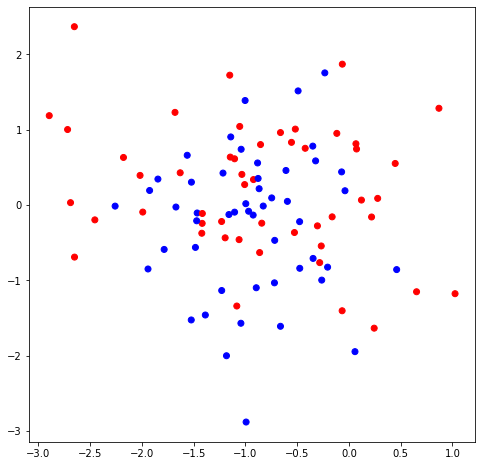

In [14]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [15]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [21]:
# Построим дерево по обучающей выборке
my_tree_1 = build_tree(train_data, train_labels, 1, type_qualitu='gini')
my_tree_2 = build_tree(train_data, train_labels, 2, type_qualitu='gini')
my_tree_3 = build_tree(train_data, train_labels, 3, type_qualitu='gini')
my_tree_4 = build_tree(train_data, train_labels, 4, type_qualitu='gini')
my_tree_5 = build_tree(train_data, train_labels, 5, type_qualitu='gini')

In [22]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [23]:
list_tree = [my_tree_1, my_tree_2, my_tree_3, my_tree_4, my_tree_5]
for i, item in enumerate(list_tree):
    print(f'Дерево - {i + 1}', print_tree(item), end='\n\n')

Индекс 0
Порог 0.05877427080072417
--> True:
  Индекс 0
  Порог -2.4538002719536713
  --> True:
    Прогноз: 0
  --> False:
    Индекс 0
    Порог -1.5208896621663803
    --> True:
      Индекс 0
      Порог -1.9248707469909265
      --> True:
        Прогноз: 1
      --> False:
        Прогноз: 1
    --> False:
      Индекс 0
      Порог -1.0067059407954793
      --> True:
        Индекс 0
        Порог -1.1587284262397282
        --> True:
          Прогноз: 1
        --> False:
          Индекс 0
          Порог -1.060571668007044
          --> True:
            Прогноз: 0
          --> False:
            Прогноз: 0
      --> False:
        Индекс 0
        Порог -0.32159682099061193
        --> True:
          Индекс 0
          Порог -0.5544817150009672
          --> True:
            Прогноз: 1
          --> False:
            Прогноз: 1
        --> False:
          Прогноз: 0
--> False:
  Прогноз: 0
Дерево - 1 None

Индекс 0
Порог 0.05877427080072417
--> True:
  Индекс 1
  Порог

In [24]:
# Получим ответы для обучающей выборки 
train_answers_1 = predict(train_data, my_tree_1)
train_answers_2 = predict(train_data, my_tree_2)
train_answers_3 = predict(train_data, my_tree_3)
train_answers_4 = predict(train_data, my_tree_4)
train_answers_5 = predict(train_data, my_tree_5)

In [25]:
# И получим ответы для тестовой выборки
answers_1 = predict(test_data, my_tree_1)
answers_2 = predict(test_data, my_tree_2)
answers_3 = predict(test_data, my_tree_3)
answers_4 = predict(test_data, my_tree_4)
answers_5 = predict(test_data, my_tree_5)

In [26]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [27]:
# Точность на обучающей выборке
train_accuracy_1 = accuracy_metric(train_labels, train_answers_1)
train_accuracy_2 = accuracy_metric(train_labels, train_answers_2)
train_accuracy_3 = accuracy_metric(train_labels, train_answers_3)
train_accuracy_4 = accuracy_metric(train_labels, train_answers_4)
train_accuracy_5 = accuracy_metric(train_labels, train_answers_5)
train = [train_accuracy_1, train_accuracy_2, train_accuracy_3, train_accuracy_4, train_accuracy_5]

In [28]:
for i, item in enumerate(train):
    print(f'Результат дерева - {i + 1}:', item, end='\n\n')

Результат дерева - 1: 75.71428571428571

Результат дерева - 2: 82.85714285714286

Результат дерева - 3: 82.85714285714286

Результат дерева - 4: 82.85714285714286

Результат дерева - 5: 100.0



In [29]:
# Точность на тестовой выборке
test_accuracy_1 = accuracy_metric(test_labels, answers_1)
test_accuracy_2 = accuracy_metric(test_labels, answers_2)
test_accuracy_3 = accuracy_metric(test_labels, answers_3)
test_accuracy_4 = accuracy_metric(test_labels, answers_4)
test_accuracy_5 = accuracy_metric(test_labels, answers_5)
test = [test_accuracy_1, test_accuracy_2, test_accuracy_3, test_accuracy_4, test_accuracy_5]

In [30]:
for i, item in enumerate(test):
    print(f'Результат дерева - {i + 1}:', item, end='\n\n')

Результат дерева - 1: 56.666666666666664

Результат дерева - 2: 53.333333333333336

Результат дерева - 3: 53.333333333333336

Результат дерева - 4: 53.333333333333336

Результат дерева - 5: 96.66666666666667



__Из полученных результатов видно качество ответов в выборке лучше у дерева, построенного на всех признаках__

#### Задание 2.
Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

In [31]:
# Расчет критерия Энтропии

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p *np.log2(p)
        
    return impurity

In [32]:
# Расчет качества добавим аргумент, тип оценки

def quality(left_labels, right_labels, current_quality,type_qualitu = 'gini'):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    if type_qualitu == 'entropy':
        return current_quality - p * entropy(left_labels) - (1 - p) * entropy(right_labels)  
    return current_quality - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [36]:
# Построим дерево с криетерием энтропии

my_tree_1 = build_tree(train_data, train_labels, 1, type_qualitu='entropy')
my_tree_2 = build_tree(train_data, train_labels, 2, type_qualitu='entropy')
my_tree_3 = build_tree(train_data, train_labels, 3, type_qualitu='entropy')
my_tree_4 = build_tree(train_data, train_labels, 4, type_qualitu='entropy')
my_tree_5 = build_tree(train_data, train_labels, 5, type_qualitu='entropy')

In [37]:
train_answers_1 = predict(train_data, my_tree_1)
train_answers_2 = predict(train_data, my_tree_2)
train_answers_3 = predict(train_data, my_tree_3)
train_answers_4 = predict(train_data, my_tree_4)
train_answers_5 = predict(train_data, my_tree_5)

In [38]:
answers_1 = predict(test_data, my_tree_1)
answers_2 = predict(test_data, my_tree_2)
answers_3 = predict(test_data, my_tree_3)
answers_4 = predict(test_data, my_tree_4)
answers_5 = predict(test_data, my_tree_5)

In [39]:
train_accuracy_1 = accuracy_metric(train_labels, train_answers_1)
train_accuracy_2 = accuracy_metric(train_labels, train_answers_2)
train_accuracy_3 = accuracy_metric(train_labels, train_answers_3)
train_accuracy_4 = accuracy_metric(train_labels, train_answers_4)
train_accuracy_5 = accuracy_metric(train_labels, train_answers_5)
train = [train_accuracy_1, train_accuracy_2, train_accuracy_3, train_accuracy_4, train_accuracy_5]

In [40]:
for i, item in enumerate(train):
    print(f'Результат дерева - {i + 1}:', item, end='\n\n')

Результат дерева - 1: 75.71428571428571

Результат дерева - 2: 82.85714285714286

Результат дерева - 3: 82.85714285714286

Результат дерева - 4: 82.85714285714286

Результат дерева - 5: 100.0



In [41]:
test_accuracy_1 = accuracy_metric(test_labels, answers_1)
test_accuracy_2 = accuracy_metric(test_labels, answers_2)
test_accuracy_3 = accuracy_metric(test_labels, answers_3)
test_accuracy_4 = accuracy_metric(test_labels, answers_4)
test_accuracy_5 = accuracy_metric(test_labels, answers_5)
test = [test_accuracy_1, test_accuracy_2, test_accuracy_3, test_accuracy_4, test_accuracy_5]

In [42]:
for i, item in enumerate(test):
    print(f'Результат дерева - {i + 1}:', item, end='\n\n')

Результат дерева - 1: 56.666666666666664

Результат дерева - 2: 53.333333333333336

Результат дерева - 3: 53.333333333333336

Результат дерева - 4: 53.333333333333336

Результат дерева - 5: 96.66666666666667



#### Задание 3.
[опция]. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [75]:
data, labels = datasets.make_regression(n_samples=500, n_features = 2, n_informative = 2, 
                                                 n_targets = 1, noise = 10, random_state = 2)

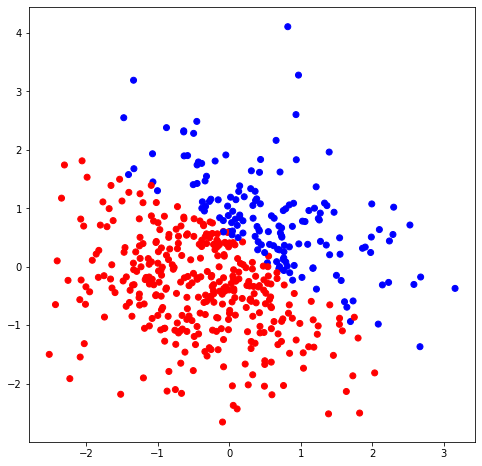

In [76]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], data)), list(map(lambda x: x[1], data)), 
              c=labels, cmap=colors)

In [79]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  
        self.t = t  
        self.true_branch = true_branch  
        self.false_branch = false_branch 
        
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        objects = []  
        for label in self.labels:
            objects.append(label)   
        objects = np.array(objects)
        prediction = objects.mean()
        return prediction

In [96]:
def dispersion(labels):
    objects = []  
    for label in labels:
        objects.append(label)
    objects = np.array(objects)
    pred = objects.mean()
    return np.mean((labels - pred) ** 2)

In [97]:
def quality(left_labels, right_labels, current_dispersion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_dispersion - p * dispersion(left_labels) - (1 - p) * dispersion(right_labels)

In [98]:
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [99]:
def find_best_split(data, labels):
    
    min_leaf = 5

    current_dispersion = dispersion(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_dispersion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [100]:
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [101]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [102]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [120]:
def calc_mse(labels, answers):
    return np.mean((labels - answers) ** 2)

In [104]:
def R2(labels, answers):
    return (1 - np.sum((answers - labels) ** 2) / np.sum((labels - np.mean(labels))**2))

In [105]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(data, 
                                                                                     labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [106]:
my_tree = build_tree(train_data, train_labels)

In [107]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1 <= 0.3564358186661671
--> True:
  Индекс 0 <= -0.07663956399736893
  --> True:
    Индекс 1 <= -0.6127515576665696
    --> True:
      Индекс 0 <= -1.5162047609820084
      --> True:
        Прогноз: -270.86275438617815
      --> False:
        Индекс 1 <= -1.778600641324842
        --> True:
          Прогноз: -222.95545274013034
        --> False:
          Индекс 0 <= -0.6815306444640257
          --> True:
            Индекс 1 <= -1.0144630635201637
            --> True:
              Прогноз: -170.8898421965565
            --> False:
              Прогноз: -151.71549129525033
          --> False:
            Индекс 1 <= -1.3334039877945194
            --> True:
              Прогноз: -156.9944320463508
            --> False:
              Индекс 0 <= -0.5598201129278841
              --> True:
                Прогноз: -131.4772296894474
              --> False:
                Прогноз: -112.11048198382466
    --> False:
      Индекс 0 <= -1.0196490994759295
      --> True

In [108]:
train_answers = predict(train_data, my_tree)

In [109]:
answers = predict(test_data, my_tree)

In [121]:
print(f'MSE train = {calc_mse(train_labels, train_answers).round(3)}')
print(f'MSE test = {calc_mse(test_labels, answers).round(3)}')

MSE train = 591.228
MSE test = 986.299


In [122]:
print(f'R2 train = {R2(train_labels, train_answers).round(3)}')
print(f'R2 test = {R2(test_labels, answers).round(3)}')

R2 train = 0.952
R2 test = 0.935
